# Code to evaluate LATMIX dye release data.
## Author: Jacob Wenegrat (jwenegrat@stanford.edu)

### Description of file: 
In this file the Knorr sections are loaded, sample section plots are made, and section averaged velocity and shear are calculated and compared to the LES. The goal of this is to confirm that the phasing of the LES cross-frontal shear is similar to the observations (ie. not an artifact of the spin-up).

In [1]:
import h5py
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d

### Load variables from LES file

In [2]:
filename = '/data/thomas/jacob13/LATMIXDYE/front.mat'
f = h5py.File(filename, 'r')

ua = f['ua']
va = f['va']
dye1 = f['dye1']
time = f['t'][:,0]
day = time/86400 + 64.5
z = f['z'][:,0]

uaz = np.gradient(ua, axis=-1)/np.gradient(z)
vaz = np.gradient(va, axis=-1)/np.gradient(z)

### Load Observations from the KNORR

In [38]:
KDIR = '/data/thomas/jacob13/LATMIXDYE/KNORR SECTIONS/'
files = sorted(os.listdir(KDIR))

rho0 = 1030
g = 9.8
Omega = 2*2*np.pi/86400

lats = []
lons = []
uzm = []
times=[]
timesec=[]
zi = np.linspace(0, 60, 20) 
udf = np.empty((zi.size,0))
vdf = np.empty((zi.size,0))
udfz = np.empty((zi.size,0))
vdfz = np.empty((zi.size,0))
dvdztotal = np.empty((zi.size,0))
nt = len(files)
udraw = ()
vdraw = ()
latraw = ()
lonraw = ()
metersraw = ()
depthraw = ()
timeraw = ()
tempraw = ()
for d in files[0:]:
    if d.endswith('.mat'):
        #print d
        kf = scipy.io.loadmat(KDIR+d)
        section = kf['section']
        latt = section['lat'][0][0][0,:][:]
        lats.extend(latt)
        lont = section['lon'][0][0][0,:][:]
        lons.extend(lont)
        time= section['time'][0][0][0,:]
        times.extend(time)
        depthk = np.array(section['depth'][0][0][0,:], dtype=np.float64)
        meters = np.array(section['meters'][0][0][:,:][:,0], dtype=np.float64)#Need to confirm this is actually survey distance
        f = np.mean(Omega*np.cos(latt*np.pi/180))
        uk = np.array(section['u'][0][0][:])
        vk = np.array(section['v'][0][0][:])
        rho = np.array(section['sigma_t'][0][0][:])
        
        b = -g * rho/rho0
        
        # Find direction of speed weighted current
        theta = np.arctan2(vk, uk)
        weight = np.sqrt(uk**2 + vk**2)
        weight[np.isnan(weight)] = 0
        theta[np.isnan(theta)] = 0
        
        tmp1 = integrate.trapz(theta*weight, x=np.abs(meters) )
        tmp1 = integrate.trapz(tmp1, x=depthk)
        tmp2 = integrate.trapz(weight, x=np.abs(meters))
        tmp2 = integrate.trapz(tmp2, x=depthk)
        theta_c = tmp1/tmp2
        
        # Calculate direction of along and across-stream current
        vd = vk*np.cos(theta_c) - uk*np.sin(theta_c)
        ud = uk*np.cos(theta_c) + vk*np.sin(theta_c)
        
        udraw = udraw + (ud,)
        vdraw = vdraw + (vd,)
        latraw = latraw + (latt,)
        lonraw = lonraw + (lont, )
        metersraw = metersraw + (meters, )
        depthraw = depthraw + (depthk, )
        timeraw = timeraw + (time,)
        tempraw = tempraw + (np.array(section['T'][0][0][:,:]),)
        duddz = np.gradient(ud, axis=0)/np.gradient(-depthk[:,np.newaxis], axis=0)
        dvddz = np.gradient(vd, axis=0)/np.gradient(-depthk[:,np.newaxis], axis=0)

        dukdz = np.gradient(uk, axis=0)/np.gradient(-depthk[:,np.newaxis], axis=0)

        dbda = np.gradient(b, axis=-1)/np.gradient(meters)
        dugdz = - dbda/f #  geostrophic shear perpendicular to survey...approximately cross-stream...
        
        duadz = duddz - dugdz
        mask = np.isfinite(duadz)
        zf = np.matlib.repmat(depthk[:,np.newaxis],1, 11)
        
        
        udbar = integrate.trapz(ud, x=meters, axis=-1)/(meters[-1]-meters[0]) #horizontal averaging
        vdbar = integrate.trapz(vd, x=meters, axis=-1)/(meters[-1]-meters[0]) #horizontal averaging
        udzbar = integrate.trapz(duadz, x=meters, axis=-1)/(meters[-1]-meters[0]) #horizontal averaging
        vdzbar = integrate.trapz(dvddz, x=meters, axis=-1)/(meters[-1]-meters[0]) #horizontal averaging
        
        #udbar = np.mean(np.ma.array(ud, mask=np.isnan(ud)), axis=1)
        #vdbar = np.mean(np.ma.array(vd, mask=np.isnan(vd)), axis=1)
        #udzbar = np.mean(np.ma.array(duddz, mask=np.isnan(duddz)), axis=1)
        #vdzbar = np.mean(np.ma.array(dvddz, mask=np.isnan(dvddz)), axis=1)

        #tmp = interp1d( depthk[mask])
        tbar = np.mean(time)
        mask = np.isfinite(udbar)
        if any(mask):
            # Along-front velocity
            tmp = interp1d( depthk[mask], udbar[mask], bounds_error=False)
            tmp = tmp(zi)
            udf = np.append(udf,tmp[:,np.newaxis], 1) 
            # Across-front velocity
            tmp = interp1d( depthk[mask], vdbar[mask], bounds_error=False)
            tmp = tmp(zi)
            vdf = np.append(vdf,tmp[:,np.newaxis], 1) 
            # Along-front shear
            tmp = interp1d( depthk[mask], udzbar[mask], bounds_error=False)
            tmp = tmp(zi)
            udfz = np.append(udfz,tmp[:,np.newaxis], 1) 
            # Across-front shear
            tmp = interp1d( depthk[mask], vdzbar[mask], bounds_error=False)
            tmp = tmp(zi)
            vdfz = np.append(vdfz,tmp[:,np.newaxis], 1) 
            timesec = np.append(timesec, (np.mean(time)))

#### Make some section plots as a basic validity check:
Note that while I am plotting along/across front velocities (ie. rotated), the temperature field is from the ship section, which is not quite in the across-front direction.


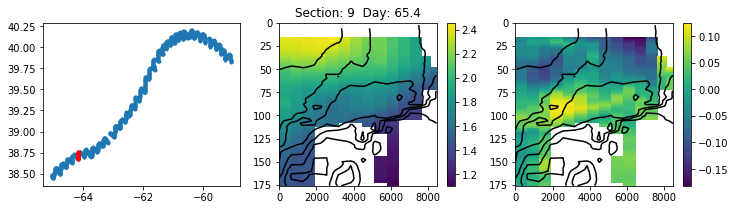

In [54]:
sectionnum = 9
cl = [-1, 1]

fig, ax = plt.subplots(1,3, figsize=(12, 3))
ax[0].plot(lons, lats, '.')
ax[0].plot(lonraw[sectionnum], latraw[sectionnum], '.', color='r')

im = ax[1].pcolor(metersraw[sectionnum], depthraw[sectionnum], udraw[sectionnum])
ax[1].invert_yaxis()
ax[1].contour(metersraw[sectionnum], depthraw[sectionnum], tempraw[sectionnum], colors='k')
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Section: ' + str(sectionnum)+ '  Day: %1.1f' % timeraw[sectionnum][0])

im = ax[2].pcolor(metersraw[sectionnum], depthraw[sectionnum], vdraw[sectionnum])
ax[2].invert_yaxis()
ax[2].contour(metersraw[sectionnum], depthraw[sectionnum], tempraw[sectionnum], colors='k')

plt.colorbar(im, ax=ax[2])

### Time series of section-averaged velocity at specific depth:
Line is LES, dots are obs.

Text(0.5,0,u'Days')

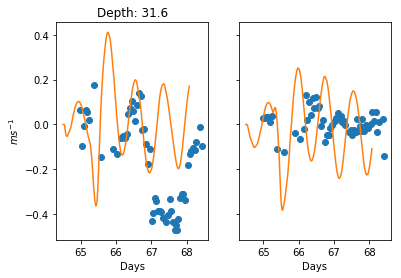

In [79]:
d = 10 #pick depth
lesind = np.where(z>-zi[d])[0][1]
fig, ax = plt.subplots(1,2, sharey=True)
# Along-front velocities
ax[0].plot(timesec, udf[d,:]-2, 'o') #Along-front velocity is shifted by 2 m/s
ax[0].plot(day, va[:,lesind])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('$m s^{-1}$')
ax[0].set_title('Depth: %1.1f' %(zi[d]))
# Across-front velocities
ax[1].plot(timesec, vdf[d,:], 'o')
ax[1].plot(day, ua[:,lesind])
#ax[1].plot(day, va[:,72])
ax[1].set_xlabel('Days')


### Time series of section-averaged shear at specific depth:
Line is LES, dots are obs.

Text(0.5,0,u'Days')

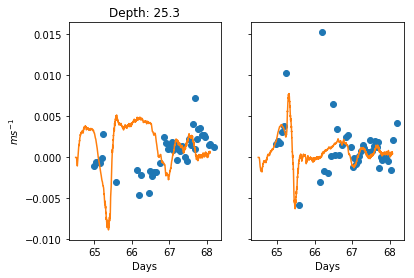

In [87]:
d = 8 #pick depth
lesind = np.where(z>-zi[d])[0][1]
fig, ax = plt.subplots(1,2, sharey=True)
# Along-front velocities
ax[0].plot(timesec, udfz[d,:], 'o') #Along-front velocity is shifted by 2 m/s
ax[0].plot(day, vaz[:,lesind])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('$m s^{-1}$')
ax[0].set_title('Depth: %1.1f' %(zi[d]))
# Across-front velocities
ax[1].plot(timesec, vdfz[d,:], 'o')
ax[1].plot(day, uaz[:,lesind])
#ax[1].plot(day, va[:,72])
ax[1].set_xlabel('Days')

### Time series of section-averaged shear averaged over certain depth range:
Line is LES, dots are obs.

Text(0.5,0,u'Days')

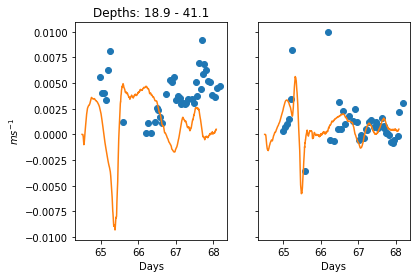

In [131]:
# Define upper and lower boundaries in meters
upb = 18
lwb = 40

upobs = (np.abs((zi) - upb)).argmin()
lwobs = (np.abs(zi - lwb)).argmin()
deltaobs = np.abs(zi[upobs]-zi[lwobs])

uples = (np.abs((-z) - upb)).argmin()
lwles = (np.abs(-z - lwb)).argmin()
deltales = z[uples]-z[lwles]

fig, ax = plt.subplots(1,2, sharey=True)
# Along-front velocities
ax[0].plot(timesec, (udf[upobs,:] - udf[lwobs,:])/deltaobs, 'o') #Along-front velocity is shifted by 2 m/s
ax[0].plot(day, (va[:,uples]-va[:,lwles])/deltales)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('$m s^{-1}$')
ax[0].set_title('Depths: %1.1f - %1.1f' %(zi[upobs], zi[lwobs]))
# Across-front velocities
ax[1].plot(timesec, (vdf[upobs,:]-vdf[lwobs,:])/deltaobs, 'o')
ax[1].plot(day, (ua[:,uples]-ua[:,lwles])/deltales)
#ax[1].plot(day, va[:,72])
ax[1].set_xlabel('Days')

## Some miscellaneous stuff follows this

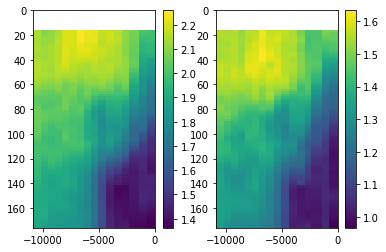

In [546]:
# Sanity check code for rotated horizontal velocities, left panel is rotated, right panel is Cartesian

cl =[-3, 3]
fig, ax = plt.subplots(1,2)
im = ax[0].pcolor(meters, depthk, ud)
plt.colorbar(im, ax=ax[0])
ax[0].invert_yaxis()

im = ax[1].pcolor(meters, depthk, uk)
plt.colorbar(im, ax=ax[1])
ax[1].invert_yaxis()

In [89]:
section.dtype #List all variables in the .mat section files


dtype([('urot', 'O'), ('vrot', 'O'), ('u', 'O'), ('v', 'O'), ('depth', 'O'), ('time', 'O'), ('meters', 'O'), ('sal', 'O'), ('T', 'O'), ('lat', 'O'), ('lon', 'O'), ('sigma_t', 'O'), ('thetashipnormal', 'O'), ('thetacurr', 'O'), ('chl', 'O'), ('f', 'O'), ('PVuf', 'O'), ('PVf', 'O'), ('N2f', 'O'), ('N2', 'O'), ('sigf', 'O'), ('zetauf', 'O')])

In [527]:
uk = np.array(section['u'][0][0][:])
vk = np.array(section['v'][0][0][:])
tk = np.array(section['time'][0][0][0,:])
tempk = np.array(section['T'][0][0][:,:])
dk = np.array(section['depth'][0][0][0,:])
lat = np.array(section['lat'][0][0][0,:])
lon = np.array(section['lon'][0][0][0,:])
meters = np.array(section['meters'][0][0][:,:][:,0])
lat

array([ 39.51584844,  39.51290562,  39.50939727,  39.50258668,
        39.49948261,  39.49758691,  39.49565913,  39.4934033 ,
        39.49066833,  39.4876817 ,  39.48449427,  39.48158786,
        39.47877549,  39.4760219 ,  39.47323952,  39.47031683,  39.46732369])